# 📂 Mount Google Drive
We mount Google Drive to store and access datasets and model checkpoints.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# 🎨 Convert Images to Sketches
This section converts real images into sketches using OpenCV (grayscale + inversion + Gaussian blur + dodge blend).


In [ ]:
import cv2
import os
import matplotlib
import matplotlib.pyplot as plt
from multiprocessing import Pool
from tqdm import tqdm

# Paths
image_path = './celeb'
sketch_path = './celeb_sketch_temp'

# Ensure output directory exists
os.makedirs(sketch_path, exist_ok=True)


def dodgeV2(image, mask):
    return cv2.divide(image, 255 - mask, scale=256)

# Process one image to sketch
def process_single_image(img):
    try:
        img_rgb = cv2.imread(os.path.join(image_path, img))
        if img_rgb is None:
            print(f"[WARNING] Skipping unreadable image: {img}")
            return
        img_gray = cv2.cvtColor(img_rgb, cv2.COLOR_BGR2GRAY)
        img_gray_inv = 255 - img_gray
        img_blur = cv2.GaussianBlur(img_gray_inv, ksize=(21, 21), sigmaX=0, sigmaY=0)
        img_blend = dodgeV2(img_gray, img_blur)
        output_path = os.path.join(sketch_path, img)
        matplotlib.image.imsave(output_path, img_blend, cmap='gray')
    except Exception as e:
        print(f"[ERROR] Failed to process {img}: {e}")

if __name__ == '__main__':
    img_names = os.listdir(image_path)
    print(f"[INFO] Found {len(img_names)} images. Starting sketch conversion using {os.cpu_count()} cores...")
    with Pool(processes=8) as pool:
        list(tqdm(pool.imap_unordered(process_single_image, img_names), total=len(img_names)))
    print("[INFO] Sketch conversion complete.")


# 📊 Count Real vs Sketch Images
We verify the number of available sketch and real images.


In [ ]:
import os

# Paths
sketch_dir = '/content/celeba_sketches_10k'
real_dir = '/content/celeba_real_images_10k'

# Count files
num_sketches = len(os.listdir(sketch_dir))
num_reals = len(os.listdir(real_dir))

print(f"🎨 Number of sketches: {num_sketches}")
print(f"🧑‍🦰 Number of real images: {num_reals}")


🎨 Number of sketches: 10000
🧑‍🦰 Number of real images: 10000


# 🚀 Copy Dataset to Local Storage
We copy images from Google Drive to Colab’s local storage for faster training.


In [ ]:
import os
import shutil

# Paths
drive_sketch = '/content/drive/MyDrive/celeba_sketches_10k'
drive_real = '/content/drive/MyDrive/celeba_real_images_10k'
local_sketch = '/content/celeba_sketches_10k'
local_real = '/content/celeba_real_images_10k'

# Create destination folders
os.makedirs(local_sketch, exist_ok=True)
os.makedirs(local_real, exist_ok=True)

# Copy 20,000 images to /content (fast local disk)
for f in sorted(os.listdir(drive_sketch))[:20000]:
    shutil.copy(os.path.join(drive_sketch, f), os.path.join(local_sketch, f))
for f in sorted(os.listdir(drive_real))[:20000]:
    shutil.copy(os.path.join(drive_real, f), os.path.join(local_real, f))

print("[✅] All files copied to local Colab storage.")


[✅] All files copied to local Colab storage.


# 🏗️ Build, Train, and Save U-Net Model

### 1. Build U-Net Model
We define the U-Net architecture for translating sketches into real images.

### 2. Train the Model
We train the U-Net model on sketch → real image mapping, saving the best weights during training.

### 3. Save Training History
After training, we store the training history (loss curves) in a pickle file for later visualization and analysis.


In [ ]:
import os, cv2, numpy as np
import matplotlib.pyplot as plt
from keras.utils import Sequence
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, Concatenate, ZeroPadding2D
from keras.callbacks import ModelCheckpoint
import tensorflow as tf
import pickle
from tqdm import tqdm


base_path = '/content'
sketch_dir = os.path.join(base_path, 'celeba_sketches_10k')
real_dir   = os.path.join(base_path, 'celeba_real_images_10k')
image_size = (218, 178)
epochs = 40
batch_size = 8


class DataGenerator(Sequence):
    def __init__(self, image_ids, sketch_path, real_path, batch_size, image_size):
        self.image_ids = image_ids
        self.sketch_path = sketch_path
        self.real_path = real_path
        self.batch_size = batch_size
        self.image_size = image_size

    def __len__(self):
        return len(self.image_ids) // self.batch_size

    def __getitem__(self, index):
        ids = self.image_ids[index * self.batch_size:(index + 1) * self.batch_size]
        X = np.zeros((self.batch_size, *self.image_size, 3), dtype=np.float32)
        y = np.zeros((self.batch_size, *self.image_size, 3), dtype=np.float32)
        for i, img_name in enumerate(ids):
            sketch = cv2.imread(os.path.join(self.sketch_path, img_name))
            real = cv2.imread(os.path.join(self.real_path, img_name))

            sketch = cv2.cvtColor(sketch, cv2.COLOR_BGR2RGB)
            real = cv2.cvtColor(real, cv2.COLOR_BGR2RGB)

            sketch = cv2.resize(sketch, (self.image_size[1], self.image_size[0])) / 255.0
            real = cv2.resize(real, (self.image_size[1], self.image_size[0])) / 255.0

            X[i] = sketch
            y[i] = real
        return X, y


image_list = sorted(os.listdir(sketch_dir))[:10000]
train_ids = image_list[:9000]
val_ids   = image_list[9000:]

print(f"Train size: {len(train_ids)} | Val size: {len(val_ids)}")

train_gen = DataGenerator(train_ids, sketch_dir, real_dir, batch_size, image_size)
val_gen   = DataGenerator(val_ids, sketch_dir, real_dir, batch_size, image_size)

def down_block(x, filters):
    c = Conv2D(filters, 3, activation='relu', padding='same')(x)
    c = Conv2D(filters, 3, activation='relu', padding='same')(c)
    p = MaxPooling2D((2, 2))(c)
    return c, p

def up_block(x, skip, filters):
    us = UpSampling2D((2, 2))(x)
    ch = skip.shape[1] - us.shape[1]
    cw = skip.shape[2] - us.shape[2]
    if ch > 0 or cw > 0:
        us = ZeroPadding2D(((ch//2, ch - ch//2), (cw//2, cw - cw//2)))(us)
    us = Concatenate()([us, skip])
    c = Conv2D(filters, 3, activation='relu', padding='same')(us)
    c = Conv2D(filters, 3, activation='relu', padding='same')(c)
    return c

def build_unet(input_shape):
    f = [16, 32, 64, 128, 256]
    inputs = Input(input_shape)

    c1, p1 = down_block(inputs, f[0])
    c2, p2 = down_block(p1, f[1])
    c3, p3 = down_block(p2, f[2])
    c4, p4 = down_block(p3, f[3])

    bn = Conv2D(f[4], 3, activation='relu', padding='same')(p4)
    bn = Conv2D(f[4], 3, activation='relu', padding='same')(bn)

    u1 = up_block(bn, c4, f[3])
    u2 = up_block(u1, c3, f[2])
    u3 = up_block(u2, c2, f[1])
    u4 = up_block(u3, c1, f[0])

    outputs = Conv2D(3, 1, activation='sigmoid', padding='same')(u4)
    return Model(inputs, outputs)

input_shape = (218, 178, 3)
model = build_unet(input_shape)
model.compile(optimizer='adam', loss='mse')
model.summary()

checkpoint = ModelCheckpoint('/content/drive/MyDrive/sketch2image_best.h5', save_best_only=True, verbose=1)
history = model.fit(train_gen, validation_data=val_gen, epochs=epochs, callbacks=[checkpoint])

with open('/content/drive/MyDrive/sketch2image_training_history.pkl', 'wb') as f:
    pickle.dump(history.history, f)

print("✅ Training complete and history saved.")


Train size: 9000 | Val size: 1000


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1             │ (None, 218, 178, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_19 (Conv2D)        │ (None, 218, 178, 16)   │            448 │ input_layer_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_20 (Conv2D)        │ (None, 218, 178, 16)   │          2,320 │ conv2d_19[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_4           │ (None, 109, 89, 16)    │              0 │ conv2d_20[0][0]        │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_21 (Conv2D)        │ (None, 109, 89, 32)    │          4,640 │ max_pooling2d_4[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_22 (Conv2D)        │ (None, 109, 89, 32)    │          9,248 │ conv2d_21[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_5           │ (None, 54, 44, 32)     │              0 │ conv2d_22[0][0]        │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_23 (Conv2D)        │ (None, 54, 44, 64)     │         18,496 │ max_pooling2d_5[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_24 (Conv2D)        │ (None, 54, 44, 64)     │         36,928 │ conv2d_23[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_6           │ (None, 27, 22, 64)     │              0 │ conv2d_24[0][0]        │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_25 (Conv2D)        │ (None, 27, 22, 128)    │         73,856 │ max_pooling2d_6[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_26 (Conv2D)        │ (None, 27, 22, 128)    │        147,584 │ conv2d_25[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_7           │ (None, 13, 11, 128)    │              0 │ conv2d_26[0][0]        │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_27 (Conv2D)        │ (None, 13, 11, 256)    │        295,168 │ max_pooling2d_7[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_28 (Conv2D)        │ (None, 13, 11, 256)    │        590,080 │ conv2d_27[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ up_sampling2d_4           │ (None, 26, 22, 256)    │              0 │ conv2d_28[0][0]        │
│ (UpSampling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ zero_padding2d_2     

 Total params: 1,962,659 (7.49 MB)

 Trainable params: 1,962,659 (7.49 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/40
1124/1125 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - loss: 0.0615
Epoch 1: val_loss improved from inf to 0.03584, saving model to /content/drive/MyDrive/sketch2image_best.h5


1125/1125 ━━━━━━━━━━━━━━━━━━━━ 64s 47ms/step - loss: 0.0614 - val_loss: 0.0358
Epoch 2/40
1124/1125 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - loss: 0.0355
Epoch 2: val_loss improved from 0.03584 to 0.03091, saving model to /content/drive/MyDrive/sketch2image_best.h5


1125/1125 ━━━━━━━━━━━━━━━━━━━━ 55s 49ms/step - loss: 0.0355 - val_loss: 0.0309
Epoch 3/40
1125/1125 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - loss: 0.0271
Epoch 3: val_loss improved from 0.03091 to 0.02588, saving model to /content/drive/MyDrive/sketch2image_best.h5


1125/1125 ━━━━━━━━━━━━━━━━━━━━ 81s 48ms/step - loss: 0.0271 - val_loss: 0.0259
Epoch 4/40
1124/1125 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - loss: 0.0238
Epoch 4: val_loss did not improve from 0.02588
1125/1125 ━━━━━━━━━━━━━━━━━━━━ 55s 49ms/step - loss: 0.0238 - val_loss: 0.0269
Epoch 5/40
1125/1125 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - loss: 0.0207
Epoch 5: val_loss improved from 0.02588 to 0.01993, saving model to /content/drive/MyDrive/sketch2image_best.h5


1125/1125 ━━━━━━━━━━━━━━━━━━━━ 55s 49ms/step - loss: 0.0207 - val_loss: 0.0199
Epoch 6/40
1125/1125 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - loss: 0.0180
Epoch 6: val_loss improved from 0.01993 to 0.01702, saving model to /content/drive/MyDrive/sketch2image_best.h5


1125/1125 ━━━━━━━━━━━━━━━━━━━━ 55s 49ms/step - loss: 0.0180 - val_loss: 0.0170
Epoch 7/40
1125/1125 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - loss: 0.0161
Epoch 7: val_loss did not improve from 0.01702
1125/1125 ━━━━━━━━━━━━━━━━━━━━ 55s 49ms/step - loss: 0.0161 - val_loss: 0.0173
Epoch 8/40
1124/1125 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - loss: 0.0146
Epoch 8: val_loss improved from 0.01702 to 0.01402, saving model to /content/drive/MyDrive/sketch2image_best.h5


1125/1125 ━━━━━━━━━━━━━━━━━━━━ 55s 49ms/step - loss: 0.0146 - val_loss: 0.0140
Epoch 9/40
1124/1125 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - loss: 0.0133
Epoch 9: val_loss did not improve from 0.01402
1125/1125 ━━━━━━━━━━━━━━━━━━━━ 82s 49ms/step - loss: 0.0133 - val_loss: 0.0142
Epoch 10/40
1125/1125 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - loss: 0.0129
Epoch 10: val_loss improved from 0.01402 to 0.01264, saving model to /content/drive/MyDrive/sketch2image_best.h5


1125/1125 ━━━━━━━━━━━━━━━━━━━━ 55s 49ms/step - loss: 0.0129 - val_loss: 0.0126
Epoch 11/40
1125/1125 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - loss: 0.0131
Epoch 11: val_loss did not improve from 0.01264
1125/1125 ━━━━━━━━━━━━━━━━━━━━ 82s 49ms/step - loss: 0.0131 - val_loss: 0.0134
Epoch 12/40
1125/1125 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - loss: 0.0121
Epoch 12: val_loss did not improve from 0.01264
1125/1125 ━━━━━━━━━━━━━━━━━━━━ 55s 49ms/step - loss: 0.0121 - val_loss: 0.0131
Epoch 13/40
1125/1125 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - loss: 0.0119
Epoch 13: val_loss improved from 0.01264 to 0.01223, saving model to /content/drive/MyDrive/sketch2image_best.h5


1125/1125 ━━━━━━━━━━━━━━━━━━━━ 55s 49ms/step - loss: 0.0119 - val_loss: 0.0122
Epoch 14/40
1124/1125 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - loss: 0.0111
Epoch 14: val_loss did not improve from 0.01223
1125/1125 ━━━━━━━━━━━━━━━━━━━━ 82s 49ms/step - loss: 0.0111 - val_loss: 0.0124
Epoch 15/40
1125/1125 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - loss: 0.0111
Epoch 15: val_loss did not improve from 0.01223
1125/1125 ━━━━━━━━━━━━━━━━━━━━ 54s 48ms/step - loss: 0.0111 - val_loss: 0.0127
Epoch 16/40
1124/1125 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - loss: 0.0107
Epoch 16: val_loss improved from 0.01223 to 0.01181, saving model to /content/drive/MyDrive/sketch2image_best.h5


1125/1125 ━━━━━━━━━━━━━━━━━━━━ 55s 49ms/step - loss: 0.0107 - val_loss: 0.0118
Epoch 17/40
1124/1125 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - loss: 0.0104
Epoch 17: val_loss did not improve from 0.01181
1125/1125 ━━━━━━━━━━━━━━━━━━━━ 55s 49ms/step - loss: 0.0104 - val_loss: 0.0123
Epoch 18/40
1125/1125 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - loss: 0.0099
Epoch 18: val_loss did not improve from 0.01181
1125/1125 ━━━━━━━━━━━━━━━━━━━━ 55s 49ms/step - loss: 0.0099 - val_loss: 0.0127
Epoch 19/40
1125/1125 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - loss: 0.0099
Epoch 19: val_loss improved from 0.01181 to 0.01179, saving model to /content/drive/MyDrive/sketch2image_best.h5


1125/1125 ━━━━━━━━━━━━━━━━━━━━ 55s 49ms/step - loss: 0.0099 - val_loss: 0.0118
Epoch 20/40
1125/1125 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - loss: 0.0094
Epoch 20: val_loss improved from 0.01179 to 0.01169, saving model to /content/drive/MyDrive/sketch2image_best.h5


1125/1125 ━━━━━━━━━━━━━━━━━━━━ 55s 49ms/step - loss: 0.0094 - val_loss: 0.0117
Epoch 21/40
1124/1125 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - loss: 0.0093
Epoch 21: val_loss did not improve from 0.01169
1125/1125 ━━━━━━━━━━━━━━━━━━━━ 82s 49ms/step - loss: 0.0093 - val_loss: 0.0118
Epoch 22/40
1124/1125 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - loss: 0.0089
Epoch 22: val_loss did not improve from 0.01169
1125/1125 ━━━━━━━━━━━━━━━━━━━━ 54s 48ms/step - loss: 0.0089 - val_loss: 0.0117
Epoch 23/40
1125/1125 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - loss: 0.0091
Epoch 23: val_loss improved from 0.01169 to 0.01167, saving model to /content/drive/MyDrive/sketch2image_best.h5


1125/1125 ━━━━━━━━━━━━━━━━━━━━ 55s 49ms/step - loss: 0.0091 - val_loss: 0.0117
Epoch 24/40
1125/1125 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - loss: 0.0085
Epoch 24: val_loss did not improve from 0.01167
1125/1125 ━━━━━━━━━━━━━━━━━━━━ 82s 49ms/step - loss: 0.0085 - val_loss: 0.0120
Epoch 25/40
1125/1125 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - loss: 0.0086
Epoch 25: val_loss did not improve from 0.01167
1125/1125 ━━━━━━━━━━━━━━━━━━━━ 54s 48ms/step - loss: 0.0086 - val_loss: 0.0125
Epoch 26/40
1125/1125 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - loss: 0.0082
Epoch 26: val_loss did not improve from 0.01167
1125/1125 ━━━━━━━━━━━━━━━━━━━━ 56s 49ms/step - loss: 0.0082 - val_loss: 0.0119
Epoch 27/40
1125/1125 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - loss: 0.0082
Epoch 27: val_loss did not improve from 0.01167
1125/1125 ━━━━━━━━━━━━━━━━━━━━ 55s 49ms/step - loss: 0.0082 - val_loss: 0.0124
Epoch 28/40
1125/1125 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - loss: 0.0081
Epoch 28: val_loss did not improve from 0.01167
1125/1125 

# 🖼️ Generate Real Image from Sketch
Run the trained model on the preprocessed sketch and visualize results.


✅ Model loaded successfully!
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 842ms/step


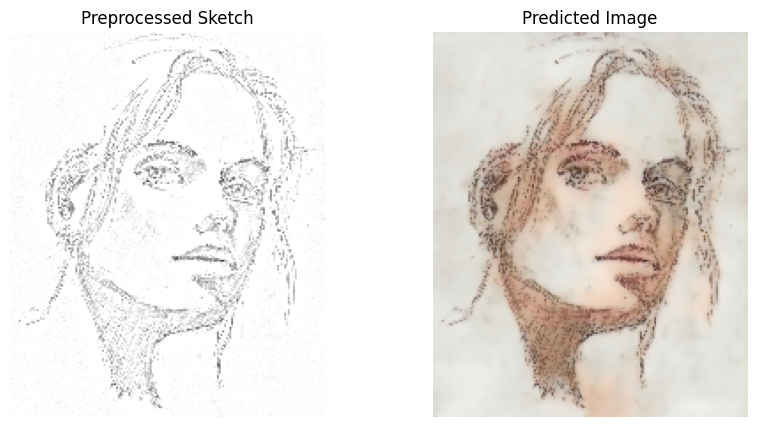

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from keras.models import load_model
import tensorflow as tf


model = load_model('/content/drive/MyDrive/sketch2image_best.h5',
                   custom_objects={'mse': tf.keras.losses.MeanSquaredError()})
print("✅ Model loaded successfully!")

def preprocess_to_sketch(image):
    img_gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    img_gray_inv = 255 - img_gray
    img_blur = cv2.GaussianBlur(img_gray_inv, ksize=(21, 21), sigmaX=0, sigmaY=0)
    sketch = cv2.divide(img_gray, 255 - img_blur, scale=256.0)
    sketch = cv2.cvtColor(sketch, cv2.COLOR_GRAY2RGB)  # Make it 3 channels for model input
    return sketch

your_sketch_file = 'new3.jpeg'
img = cv2.imread(your_sketch_file)
img = cv2.resize(img, (178, 218))  # Resize to match training
img_preprocessed = preprocess_to_sketch(img)


img_input = img_preprocessed.astype(np.float32) / 255.0
img_input = np.expand_dims(img_input, axis=0)

# ✅ Predict
predicted = model.predict(img_input)[0]
predicted = (predicted * 255).astype(np.uint8)

# ✅ Show preprocessed sketch and predicted image
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(img_preprocessed)
plt.title("Preprocessed Sketch")
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(predicted)
plt.title("Predicted Image")
plt.axis('off')
plt.show()
